`**1. Datasets: ML-100K dataset**

Model: GRU4Rec
Train size: 80000, Test size: 20000
Number of users in train set: 751, Number of users in test set: 301
Number of items in train set: 1616, Number of items in test set: 1448
Number of cold-start users (only in test set): 192
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - loss: 7.2767 - sparse_categorical_accuracy: 1.8076e-04 - val_loss: 6.7841 - val_sparse_categorical_accuracy: 2.5699e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
User 0 - True: {'255'}, Pred: ['1', '97', '96', '50', '300', '288', '257', '172', '22', '173']
User 1 - True: {'200', '473'}, Pred: ['1', '97', '96', '50', '300', '288', '257', '172', '22', '173']
User 2 - True: {'357', '687'}, Pred: ['1', '97', '96', '50', '300', '288', '257', '172', '22', '173']
User 3 - True: {'298', '523', '806', '71', '233', '939', '2', '553', '474', '55', '924', '228', '1153', '213', '120', '92', '1086', '515', '68', '211', '290', '496', '382', '977', '540', '1016', '824', '718', '770', '144', '451', '50', '117', '4

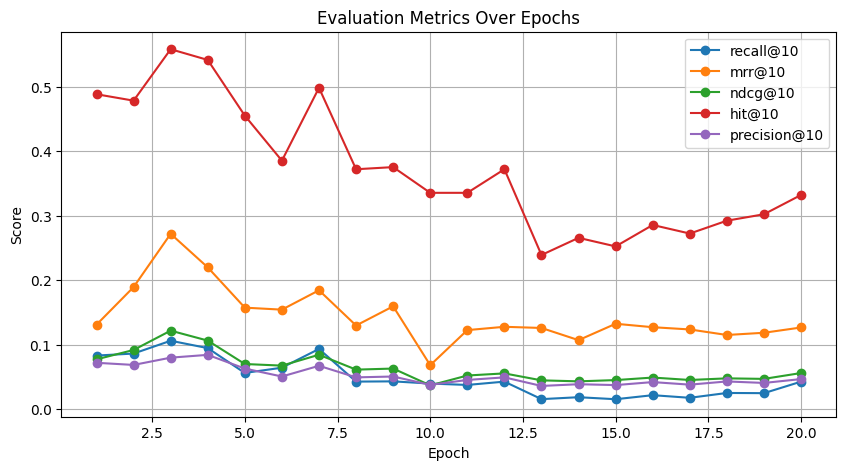

Training Completed! Metrics history saved to metrics_history.json


In [4]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

url_base = "https://files.grouplens.org/datasets/movielens/ml-100k/"
df = pd.read_csv(url_base + "u.data", sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv(url_base + "u.item", sep='|', encoding='latin-1', header=None, engine='python',
                      names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

users = pd.read_csv(url_base + "u.user", sep='|', header=None,
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on='user_id', how='left')
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s').astype(int) // 10**9
df = df.merge(movies, on='item_id', how='left')
df.drop(columns=['IMDb_URL', 'video_release_date', 'unknown'], inplace=True)

df = df.sort_values(by=['timestamp'])

unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
# idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows()}
idx_to_title = {item_to_idx.get(row['item_id'], None): row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}

def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

print(f"Model: GRU4Rec")
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

# Identify cold-start users (users present only in test set)
cold_start_users = set(test_df['user_id']) - set(train_df['user_id'])
print(f"Number of cold-start users (only in test set): {len(cold_start_users)}")
train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

max_seq_len = 512

def mask_items(sequences, mask_prob=0.2):
    masked_sequences, labels = [], []
    for seq in sequences:
        masked_seq = seq[:]
        label = [-1] * len(seq)
        for i in range(len(seq)):
            if np.random.rand() < mask_prob:
                label[i] = masked_seq[i]
                masked_seq[i] = 0

        if all(l == -1 for l in label):
            random_idx = np.random.randint(len(seq))
            label[random_idx] = masked_seq[random_idx]
            masked_seq[random_idx] = 0

        label = [l if l != -1 else 0 for l in label]
        masked_seq = masked_seq[:max_seq_len] + [0] * (max_seq_len - len(masked_seq))
        label = label[:max_seq_len] + [0] * (max_seq_len - len(label))

        masked_sequences.append(masked_seq)
        labels.append(label)
    return np.array(masked_sequences, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = mask_items(train_sequences['item_id'].tolist())
test_input, test_labels = mask_items(test_sequences['item_id'].tolist())

class MaskedLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

gru_units = 129

class GRU4Rec(tf.keras.Model):
    def __init__(self, vocab_size, gru_units=128):
        super(GRU4Rec, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=gru_units)
        self.gru = tf.keras.layers.GRU(gru_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        x = self.embedding(input_ids)
        x = self.gru(x, training=training)
        logits = self.dense(x)
        return logits

model = GRU4Rec(vocab_size=len(item_to_idx) + 1, gru_units=gru_units)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=MaskedLoss(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

def evaluate_metrics(model, test_input, test_labels, top_k=10):
    predictions = model.predict(test_input)
    logits = predictions[:, -1, :]  # Last position logits for all users
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    num_samples = len(test_labels)

    for i in range(num_samples):
        # Convert true item indices to actual item IDs
        true_items = set([idx_to_item[idx] for idx in np.where(test_labels[i] > 0)[0] if idx in idx_to_item])

        # Get top-K predictions, excluding seen items
        pred_items = [
            idx_to_item[int(idx)] for idx in np.argsort(logits[i])[::-1]
            if int(idx) in idx_to_item and idx not in true_items
        ][:top_k]

        pred_items_set = set(pred_items)

        if i < 5:
            print(f"User {i} - True: {true_items}, Pred: {pred_items}")

        # Compute Metrics
        correct_preds = len(true_items & pred_items_set)
        recall += correct_preds / len(true_items) if len(true_items) > 0 else 0

        for rank, item in enumerate(pred_items, start=1):
            if item in true_items:
                mrr += 1 / rank
                break

        dcg = sum([(1 / np.log2(rank + 2)) if pred_items and pred_items[rank] in true_items else 0 for rank in range(min(len(pred_items), top_k))])
        idcg = sum([1 / np.log2(rank + 2) for rank in range(min(len(true_items), top_k))])
        ndcg += dcg / idcg if idcg > 0 else 0

        hit += int(correct_preds > 0) if pred_items else 0
        precision += correct_preds / top_k if pred_items else 0

    return recall / num_samples, mrr / num_samples, ndcg / num_samples, hit / num_samples, precision / num_samples

metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

for epoch in range(20):
    print(f"Epoch {epoch+1}/20")
    model.fit(train_input, train_labels, validation_split=0.1, epochs=1, batch_size=16, verbose=1)
    recall, mrr, ndcg, hit, precision = evaluate_metrics(model, test_input, test_labels)
    print(f"Metrics at epoch {epoch+1}:")
    print(f"Recall@10: {recall:.8f}, MRR@10: {mrr:.8f}, NDCG@10: {ndcg:.8f}, Hit@10: {hit:.8f}, Precision@10: {precision:.8f}")
    metrics_history["recall@10"].append(recall)
    metrics_history["mrr@10"].append(mrr)
    metrics_history["ndcg@10"].append(ndcg)
    metrics_history["hit@10"].append(hit)
    metrics_history["precision@10"].append(precision)
    print(metrics_history)

def recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    top_indices = [idx for idx in np.argsort(logits)[::-1] if idx not in watched_items_set][:top_k]

    print(f"Top Recommended Items for User ID {user_id}:")
    recommended_items = []

    for i, idx in enumerate(top_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return recommended_items

def least_recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    bottom_indices = [idx for idx in np.argsort(logits) if idx not in watched_items_set][:top_k]

    print(f"Least Recommended Items for User ID {user_id}:")
    least_recommended_items = []

    for i, idx in enumerate(bottom_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            least_recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return least_recommended_items

recommend_items(user_id=1, top_k=10)
recommend_items(user_id=2, top_k=10)

import matplotlib.pyplot as plt

# Plot the metrics over epochs
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

import json

# Save metrics history to a JSON file
with open("metrics_history.json", "w") as f:
    json.dump(metrics_history, f, indent=4)

print("Training Completed! Metrics history saved to metrics_history.json")

Summary Statistics for ML-100k dataset, containing 100,000 movie ratings from 943 users on 1,682 movies.


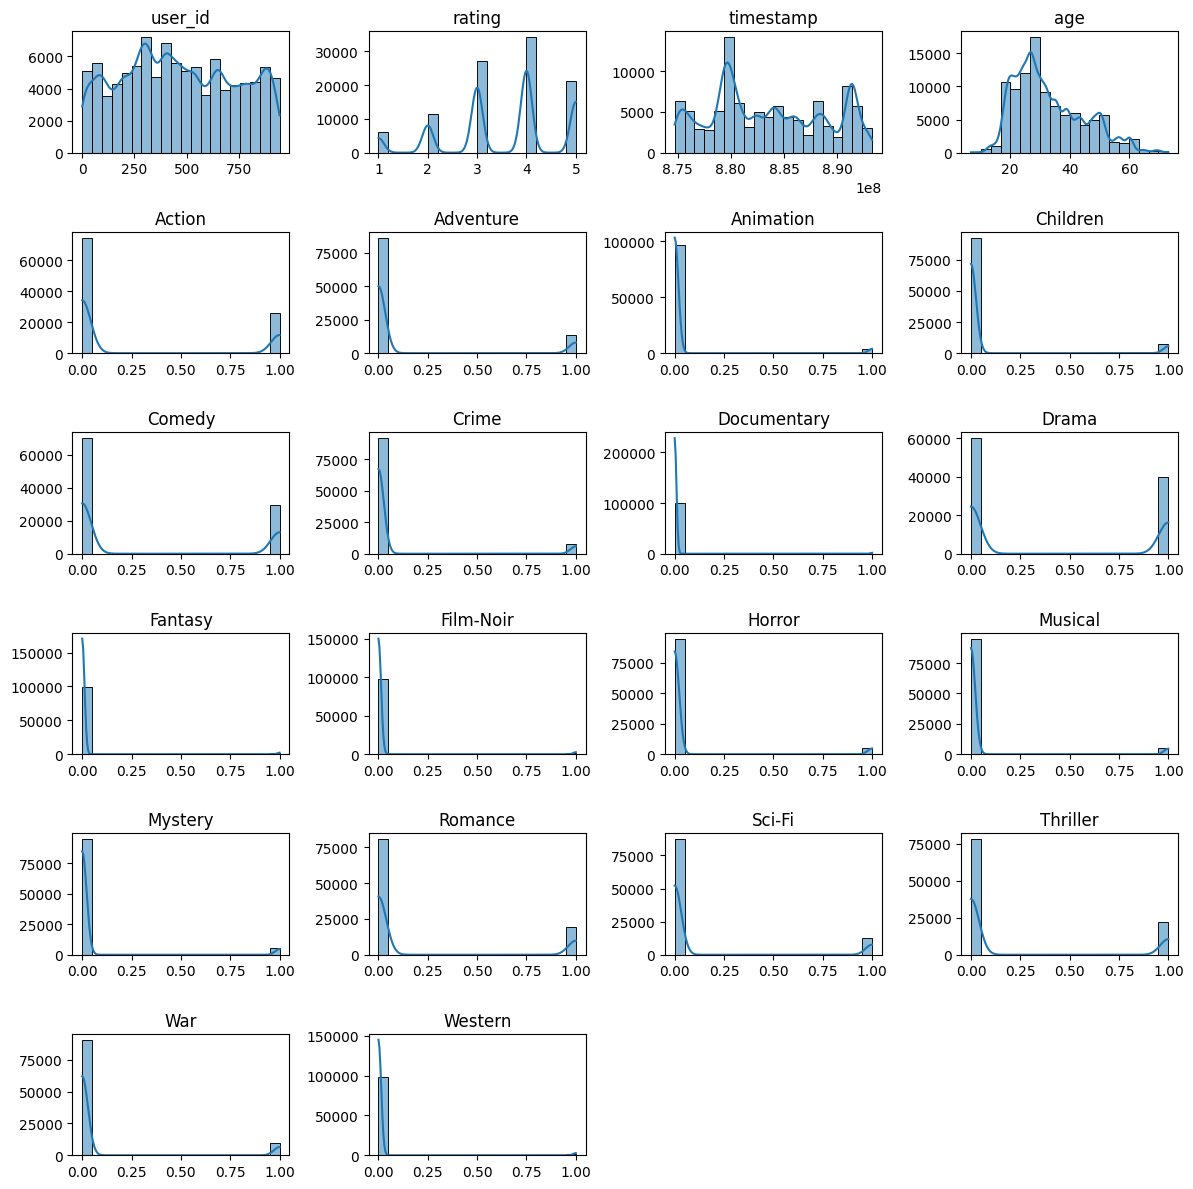

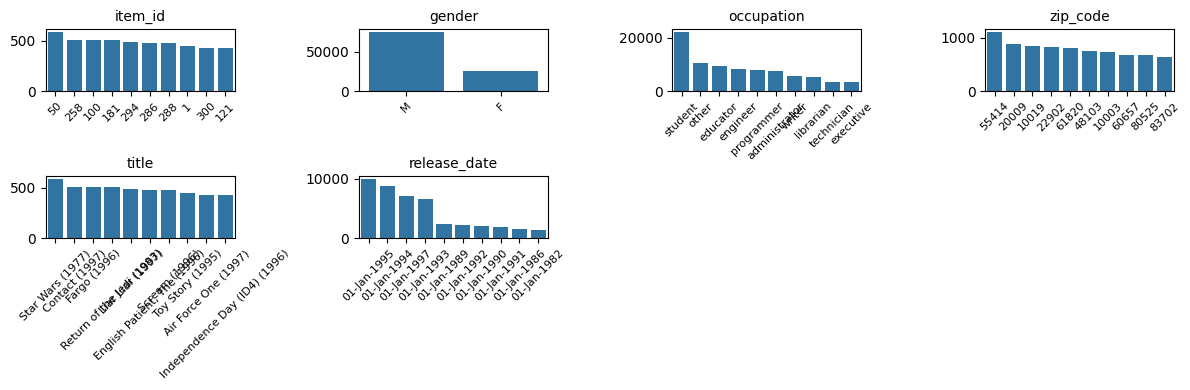

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Summary Statistics for ML-100k dataset, containing 100,000 movie ratings from 943 users on 1,682 movies.")

# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Plot numeric features
num_cols = 4
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

# Plot categorical features
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index[:10])
    plt.xticks(rotation=45, fontsize=8)
    plt.title(f"{col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

**2. Datasets: ML-1M dataset** (Fine tuning is in progress)

The ML-1M dataset is the MovieLens 1M dataset, containing 1,000,000 movie ratings from 6,040 users on 3,900 movies.
All previous model files deleted in ./saved/
--2025-02-03 17:18:50--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./saved/ml-1m.zip’

./saved/ml-1m.zip   100%[===================>]   5.64M  23.8MB/s    in 0.2s    

2025-02-03 17:18:50 (23.8 MB/s) - ‘./saved/ml-1m.zip’ saved [5917549/5917549]

Dataset already extracted.

Sample data from the merged dataset:


,user_id,item_id,rating,timestamp,gender,age,occupation,zip_code,title,genres
429189,2611,3300,2,2000-11-08 23:22:13,M,25,3,07719,Pitch Black (2000),Action|Sci-Fi
205188,1262,1210,3,2000-11-21 15:15:08,M,25,4,22903,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
35019,237,2150,4,2001-06-24 00:57:23,M,25,6,46835,"Gods Must Be Crazy, The (1980)",Comedy
829731,4981,1269,4,2000-07-03 04:07:59,M,50,1,55406,Arsenic and Old Lace (1944),Comedy|Mystery|Thriller
962984,5806,1247,4,2000-05-10 19:09:48,F,50,1,08826,"Graduate, The (1967)",Drama|Romance
767026,4568,1028,3,2000-07-24 22:38:09,F,25,4,90034,Mary Poppins (1964),Children's|Comedy|Musical
486288,2994,3898,4,2000-10-05 01:16:50,M,35,5,95008,Bait (2000),Action|Comedy
130503,846,2872,3,2001-03-13 03:46:51,M,25,5,80209,Excalibur (1981),Action|Drama|Fantasy|Romance
129338,839,428,4,2001-01-24 02:40:07,M,25,0,98103,"Bronx Tale, A (1993)",Drama
426573,2590,1917,3,2000-11-11 08:24:19,M,18,4,94044,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller



Processed dataset saved at: ./saved/movielens_1m_processed.csv
Model: GRU4Rec
Train size: 800167, Test size: 200042
Number of users in train set: 5400, Number of users in test set: 1783
Number of items in train set: 3662, Number of items in test set: 3511
Number of cold-start users (only in test set): 640
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 151s 490ms/step - loss: 7.6490 - sparse_categorical_accuracy: 1.7858e-04 - val_loss: 7.2227 - val_sparse_categorical_accuracy: 2.4957e-04
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step
User 0 - True: {'759', '1111', '1649', '1252', '2503', '608', '1094', '2762', '300', '1961', '2384', '247', '2019', '265', '549'}, Pred: ['1036', '2571', '110', '1240', '1270', '2028', '589', '1196', '593', '2858']
User 1 - True: {'150', '348', '1188', '45', '17', '446', '3545', '2391', '866', '162', '50', '3022', '34', '3548', '2692', '1961', '508', '1617', '919', '3471', '318', '1211', '1276'}, Pred: ['1036', '2571', '110', '1240', '1270', '2028', '1196', '589', '45

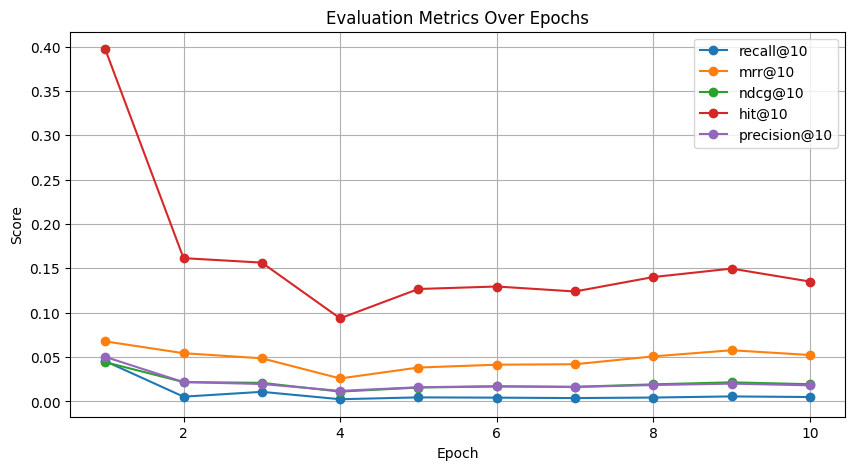

Training Completed! Metrics history saved to metrics_history.json


In [7]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("The ML-1M dataset is the MovieLens 1M dataset, containing 1,000,000 movie ratings from 6,040 users on 3,900 movies.")

# Further Fine Tuning Required

warnings.filterwarnings("ignore")

checkpoint_dir = "./saved/"
zip_path = "./saved/ml-1m.zip"
extract_path = "./saved/ml-1m/"

if os.path.exists(checkpoint_dir):
    for file in os.listdir(checkpoint_dir):
        file_path = os.path.join(checkpoint_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    print(f"All previous model files deleted in {checkpoint_dir}")
else:
    os.makedirs(checkpoint_dir)

# MovieLens 1M dataset
if not os.path.exists(zip_path):
    print("Downloading MovieLens 1M dataset...")
    !wget -O $zip_path "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
else:
    print("Dataset already downloaded.")

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    !unzip -o $zip_path -d $checkpoint_dir
else:
    print("Dataset already extracted.")

ratings_file = os.path.join(extract_path, "ratings.dat")
movies_file = os.path.join(extract_path, "movies.dat")
users_file = os.path.join(extract_path, "users.dat")

df = pd.read_csv(ratings_file, sep="::", names=['user_id', 'item_id', 'rating', 'timestamp'], engine="python")
movies = pd.read_csv(movies_file, sep="::", encoding="latin-1", header=None, engine="python",
                     names=['item_id', 'title', 'genres'])
users = pd.read_csv(users_file, sep="::", header=None, engine="python",
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

df['item_id'] = df['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)
df = df.merge(users, on="user_id", how="left")
df = df.merge(movies, on="item_id", how="left")

# Display dataset sample
print("\nSample data from the merged dataset:")
display(df.sample(10))  # Show 10 random rows

# Optional: Save processed dataset
df.to_csv("./saved/movielens_1m_processed.csv", index=False)
print("\nProcessed dataset saved at: ./saved/movielens_1m_processed.csv")

df = df.sort_values(by=['timestamp'])

unique_items = df['item_id'].unique()
item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}
# idx_to_title = {item_to_idx[row['item_id']]: row['title'] for _, row in movies.iterrows()}
idx_to_title = {item_to_idx.get(row['item_id'], None): row['title'] for _, row in movies.iterrows() if row['item_id'] in item_to_idx}


def tokenize_data(data):
    return data.groupby('user_id')['item_id'].apply(lambda x: [item_to_idx.get(i, 0) for i in x]).reset_index()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

print(f"Model: GRU4Rec")
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Number of users in train set: {train_df['user_id'].nunique()}, Number of users in test set: {test_df['user_id'].nunique()}")
print(f"Number of items in train set: {train_df['item_id'].nunique()}, Number of items in test set: {test_df['item_id'].nunique()}")

# Identify cold-start users (users present only in test set)
cold_start_users = set(test_df['user_id']) - set(train_df['user_id'])
print(f"Number of cold-start users (only in test set): {len(cold_start_users)}")
train_sequences = tokenize_data(train_df)
test_sequences = tokenize_data(test_df)

max_seq_len = 512

def mask_items(sequences, mask_prob=0.2):
    masked_sequences, labels = [], []
    for seq in sequences:
        masked_seq = seq[:]
        label = [-1] * len(seq)
        for i in range(len(seq)):
            if np.random.rand() < mask_prob:
                label[i] = masked_seq[i]
                masked_seq[i] = 0

        if all(l == -1 for l in label):
            random_idx = np.random.randint(len(seq))
            label[random_idx] = masked_seq[random_idx]
            masked_seq[random_idx] = 0

        label = [l if l != -1 else 0 for l in label]
        masked_seq = masked_seq[:max_seq_len] + [0] * (max_seq_len - len(masked_seq))
        label = label[:max_seq_len] + [0] * (max_seq_len - len(label))

        masked_sequences.append(masked_seq)
        labels.append(label)
    return np.array(masked_sequences, dtype=np.int32), np.array(labels, dtype=np.int32)

train_input, train_labels = mask_items(train_sequences['item_id'].tolist())
test_input, test_labels = mask_items(test_sequences['item_id'].tolist())

class MaskedLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

gru_units = 129

class GRU4Rec(tf.keras.Model):
    def __init__(self, vocab_size, gru_units=128):
        super(GRU4Rec, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=gru_units)
        self.gru = tf.keras.layers.GRU(gru_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_ids, training=False):
        x = self.embedding(input_ids)
        x = self.gru(x, training=training)
        logits = self.dense(x)
        return logits

model = GRU4Rec(vocab_size=len(item_to_idx) + 1, gru_units=gru_units)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=MaskedLoss(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

def evaluate_metrics(model, test_input, test_labels, top_k=10):
    predictions = model.predict(test_input)
    logits = predictions[:, -1, :]  # Last position logits for all users
    recall, mrr, ndcg, hit, precision = 0, 0, 0, 0, 0
    num_samples = len(test_labels)

    for i in range(num_samples):
        # Convert true item indices to actual item IDs
        true_items = set([idx_to_item[idx] for idx in np.where(test_labels[i] > 0)[0] if idx in idx_to_item])

        # Get top-K predictions, excluding seen items
        pred_items = [
            idx_to_item[int(idx)] for idx in np.argsort(logits[i])[::-1]
            if int(idx) in idx_to_item and idx not in true_items
        ][:top_k]

        pred_items_set = set(pred_items)

        if i < 5:
            print(f"User {i} - True: {true_items}, Pred: {pred_items}")

        # Compute Metrics
        correct_preds = len(true_items & pred_items_set)
        recall += correct_preds / len(true_items) if len(true_items) > 0 else 0

        for rank, item in enumerate(pred_items, start=1):
            if item in true_items:
                mrr += 1 / rank
                break

        dcg = sum([(1 / np.log2(rank + 2)) if pred_items and pred_items[rank] in true_items else 0 for rank in range(min(len(pred_items), top_k))])
        idcg = sum([1 / np.log2(rank + 2) for rank in range(min(len(true_items), top_k))])
        ndcg += dcg / idcg if idcg > 0 else 0

        hit += int(correct_preds > 0) if pred_items else 0
        precision += correct_preds / top_k if pred_items else 0

    return recall / num_samples, mrr / num_samples, ndcg / num_samples, hit / num_samples, precision / num_samples

metrics_history = {"recall@10": [], "mrr@10": [], "ndcg@10": [], "hit@10": [], "precision@10": []}

for epoch in range(10):
    print(f"Epoch {epoch+1}/10")
    model.fit(train_input, train_labels, validation_split=0.1, epochs=1, batch_size=16, verbose=1)
    recall, mrr, ndcg, hit, precision = evaluate_metrics(model, test_input, test_labels)
    print(f"Metrics at epoch {epoch+1}:")
    print(f"Recall@10: {recall:.8f}, MRR@10: {mrr:.8f}, NDCG@10: {ndcg:.8f}, Hit@10: {hit:.8f}, Precision@10: {precision:.8f}")
    metrics_history["recall@10"].append(recall)
    metrics_history["mrr@10"].append(mrr)
    metrics_history["ndcg@10"].append(ndcg)
    metrics_history["hit@10"].append(hit)
    metrics_history["precision@10"].append(precision)
    print(metrics_history)

def recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    top_indices = [idx for idx in np.argsort(logits)[::-1] if idx not in watched_items_set][:top_k]

    print(f"Top Recommended Items for User ID {user_id}:")
    recommended_items = []

    for i, idx in enumerate(top_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return recommended_items

def least_recommend_items(user_id, top_k=10):
    user_sequence_row = train_sequences.loc[train_sequences['user_id'] == user_id]

    if user_sequence_row.empty:
        print(f"No interaction history found for User ID {user_id}.")
        return []

    user_sequence = user_sequence_row['item_id'].values[0]
    watched_items_set = set(user_sequence)

    input_sequence = np.array([user_sequence + [0] * (max_seq_len - len(user_sequence))])

    predictions = model(input_sequence, training=False).numpy()[0]
    logits = predictions[-1]
    probabilities = tf.nn.softmax(logits).numpy()

    bottom_indices = [idx for idx in np.argsort(logits) if idx not in watched_items_set][:top_k]

    print(f"Least Recommended Items for User ID {user_id}:")
    least_recommended_items = []

    for i, idx in enumerate(bottom_indices):
        if idx != 0:
            item_id = idx_to_item[idx]
            item_name = idx_to_title[idx]
            logit_score = logits[idx]
            prob_score = probabilities[idx]
            least_recommended_items.append((item_id, item_name, logit_score, prob_score))
            print(f"{i+1}. Item ID: {item_id}, Name: {item_name}, Logit Score: {logit_score:.4f}, Probability: {prob_score:.4f}")

    return least_recommended_items

recommend_items(user_id=1, top_k=10)
recommend_items(user_id=2, top_k=10)

import matplotlib.pyplot as plt

# Plot the metrics over epochs
plt.figure(figsize=(10, 5))
for metric_name, values in metrics_history.items():
    plt.plot(range(1, len(values) + 1), values, marker='o', label=metric_name)

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

import json

# Save metrics history to a JSON file
with open("metrics_history.json", "w") as f:
    json.dump(metrics_history, f, indent=4)

print("Training Completed! Metrics history saved to metrics_history.json")

Summary Statistics for MovieLens 1M dataset, containing 1,000,000 movie ratings from 6,040 users on 3,900 movies.


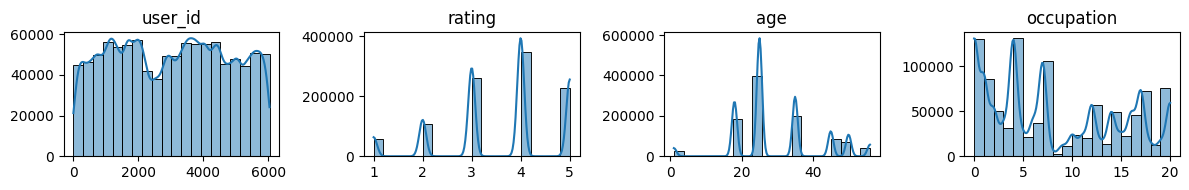

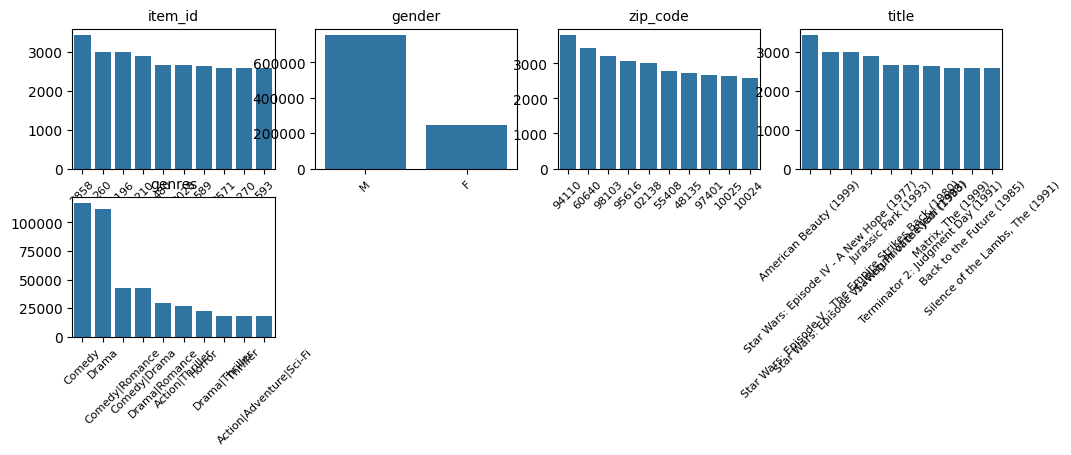

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Summary Statistics for MovieLens 1M dataset, containing 1,000,000 movie ratings from 6,040 users on 3,900 movies.")

# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Plot numeric features
num_cols = 4
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

# Plot categorical features
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 3, num_rows * 2))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index[:10])
    plt.xticks(rotation=45, fontsize=8)
    plt.title(f"{col}", fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
plt.tight_layout()
plt.show()

In [9]:
!pip install recbole ray kmeans_pytorch optuna wandb surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB

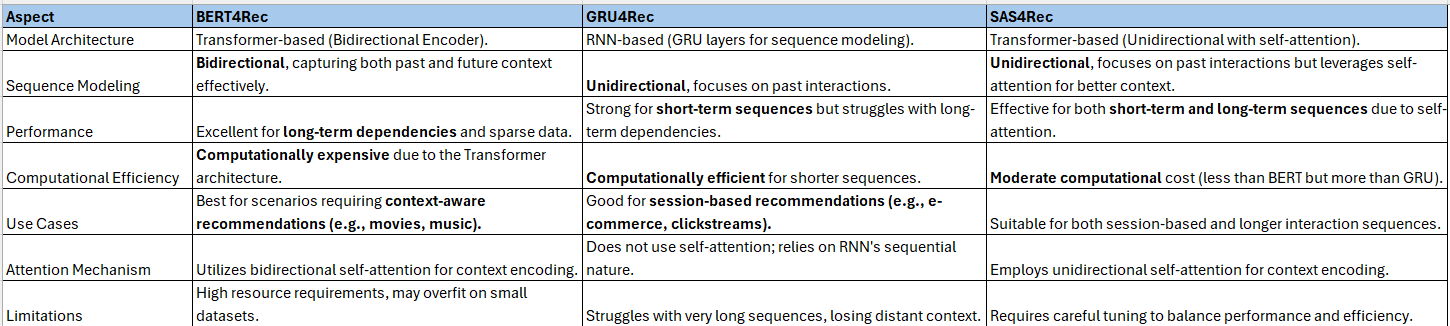